In [1]:
import numpy as np
import pandas as pd
import librosa

import os
import time
import re
from tqdm import tqdm
import h5py

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model

import matplotlib.pyplot as plt
import IPython.display
import librosa.display

import ESC 


# Use GPU
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3190001537273715647
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15484021983181893580
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7046801664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13728579723420920516
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13115499738865152414
physical_device_desc: "device: XLA_GPU device"
]


## Load Data


In [2]:
train_d, train_l, val_d, val_l, test_d, test_l = ESC.Load_Segments('ESC10', 1)

In [39]:
def Compute_MelSpec(dataset, bands=60):

    features = []
    for segment in dataset:
        features.append(librosa.core.amplitude_to_db(librosa.feature.melspectrogram(segment, n_mels=bands)))
    
    log_specgrams = np.asarray(features).reshape(len(features), bands, 41, 1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis=3)

    for i in range(len(log_specgrams)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    features = features.astype(np.float32)    
    return features

In [4]:
features = Compute_MelSpec(train_d, bands=60)

features_v = Compute_MelSpec(val_d, bands=60)

100%|██████████| 1559/1559 [00:03<00:00, 425.38it/s]


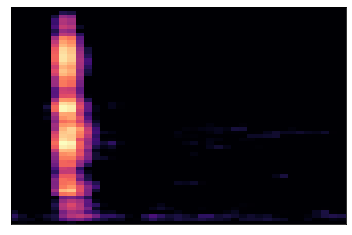

In [5]:
librosa.display.specshow(features[4500, :, :, 0], sr=22050)

In [6]:
np.argmax(train_l[9])

9

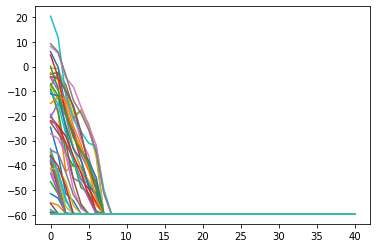

In [7]:
plt.figure()
for band in features[5, :, :, 0]:
    plt.plot(band)
plt.show()

In [8]:
# Scale the data in each fold to 0 1
scaled_features = np.interp(features, (-100., 150.), (0, 1))
scaled_features_v = np.interp(features_v, (-100., 150.), (0, 1))

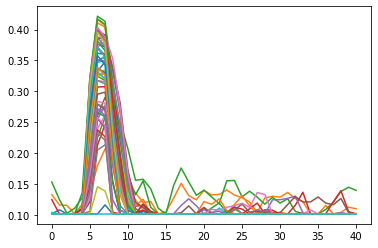

In [9]:
plt.figure()
for band in scaled_features[4500, :, :, 0]:
    plt.plot(band)
plt.show()

In [10]:
from AudioDataGenerator_mod import AudioDataGenerator
datagen = AudioDataGenerator(
                            horizontal_flip=True,
                            noise=True,
                            pitch_s=True,)

# Define Network and Training

In [11]:
def PiczakNet(input_shape):
    
    X_input = tf.keras.Input(input_shape)
    
    # First convolution block
    model = tf.keras.layers.Conv2D(80, kernel_size=(57, 6), strides=1, padding='same', name='conv0')(X_input)
    model = tf.keras.layers.Activation('relu')(model)
    model = tf.keras.layers.MaxPool2D(pool_size=(4, 3), strides=(1, 3), padding='same')(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    
    # Second convolution block
    model = tf.keras.layers.Conv2D(80, kernel_size=(1, 3), strides=1, padding='same', name='conv1')(model)
    model = tf.keras.layers.Activation('relu')(model)
    model = tf.keras.layers.MaxPool2D(pool_size=(1, 3), strides=(1, 3), padding='same')(model)
    
    # Flatten
    model = tf.keras.layers.Flatten()(model)
    
    # First fully-connected block
    model = tf.keras.layers.Dense(5000, activation='relu', name='fc0')(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    
    # Second fully-connected block
    model = tf.keras.layers.Dense(5000, activation='relu', name='fc1')(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    
    # Output layer
    model = tf.keras.layers.Dense(10, activation=None, name='out')(model)
    
    # Create model
    model = tf.keras.Model(inputs = X_input, outputs = model, name='PiczakNet')
    
    return model

In [12]:
PiczakNet = PiczakNet([60, 41, 2])
print(PiczakNet.summary())
plot_model(PiczakNet, show_shapes=True, show_layer_names=True)

opt = tf.keras.optimizers.Adam(lr=0.0002)
loss_f = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
PiczakNet.compile(optimizer=opt, loss=loss_f, metrics=["accuracy"])

Model: "PiczakNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 41, 2)]       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 60, 41, 80)        54800     
_________________________________________________________________
activation (Activation)      (None, 60, 41, 80)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 14, 80)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 14, 80)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 60, 14, 80)        19280     
_________________________________________________________________
activation_1 (Activation)    (None, 60, 14, 80)        0 

In [44]:
def CreateTrainingSet(data, label, batch_size=32):
    
    # Shuffle the folds
    rnd_indices = np.arange(0, len(data))
    rnd_indices = np.random.shuffle(rnd_indices)
    
    data = data[rnd_indices].reshape((len(data), len(data[0])))
    label = label[rnd_indices].reshape((len(label), 10))
    
    
    data = data.astype(np.float32)
    label = label.astype(np.float32)

    # Create dataset
    training_dataset = tf.data.Dataset.from_tensor_slices((data, label))
    
    # Cache the dataset
    training_dataset = training_dataset.cache("training_cache")
    
    # Shuffle all elements at every iteration
    training_dataset = training_dataset.shuffle(len(training_dataset))
    
    # Define batch_size and prefetch size
    training_dataset = training_dataset.batch(batch_size=batch_size).prefetch(buffer_size=1)
    
    return training_dataset



def CreateValidationSet(data, label, batch_size=32):
    
    data = data.astype(dtype=np.float32)
    label = label.astype(dtype=np.float32)
    
    # Create and cache training
    validation_dataset = tf.data.Dataset.from_tensor_slices((data, label))
    
    # Cache dataset
    validation_dataset = validation_dataset.cache("validation_cache")
    
    # Define batch_size and prefetch size
    validation_dataset = validation_dataset.batch(batch_size=batch_size).prefetch(buffer_size=1)
    
    return validation_dataset


# Generate shifting augmentation
def Pitch_Augmentation(data_batch, ratio=0.2):
    '''
        Input:
            data:              data sample to augment
            number:            number of augmentations
        
        Output:
            augmented_data:    augmented data with pitch variation
    '''
    pitch_factor = np.random.uniform(-12, 12, len(data_batch))
    values = np.random.uniform(0, 1, len(data_batch))
    
    for i in range(len(data_batch)):
        if(values[i]<ratio):
            data_batch[i] = librosa.effects.pitch_shift(data_batch[i], 22050, pitch_factor[i])

    return data_batch


# Generate shifting augmentation
def Invert_Augmentation(data_batch, ratio=0.2):
    '''
        Input:
            data:              data sample to augment
            number:            number of augmentations
        
        Output:
            augmented_data:    augmented data with pitch variation
    '''
    values = np.random.uniform(0, 1, len(data_batch))
    
    for i in range(len(data_batch)):
        if(values[i]<ratio):
            data_batch[i] = np.flip(x, axis=data_row_axis)

    return data_batch


def Data_Augmentation(data_batch, ratio=0.2):
    
    
    pitch_factor = np.random.uniform(-12, 12, len(data_batch))
    n_r = np.random.uniform(0, 1, len(data_batch))
    p_r = np.random.uniform(0, 1, len(data_batch))
    i_r = np.random.uniform(0, 1, len(data_batch))
    
    aug = np.zeros(np.shape(data_batch))
    # Loop over samples
    for i in range(len(data_batch)):
        
        if(p_r[i]<ratio):
            aug[i] = librosa.effects.pitch_shift(np.asarray(data_batch[i]), 22050, pitch_factor[i])
            
        if(n_r[i]<ratio):
            aug[i] = data_batch[i] + np.random.uniform(0.001, 0.05, size=len(data_batch[i]))
        
        if(i_r[i]<ratio):
            aug[i] = np.flip(data_batch[i])
    
    return aug

ModuleNotFoundError: No module named 'tensorflow_io'

In [36]:
training_dataset = CreateTrainingSet(train_d, train_l, batch_size=128)
validation_dataset = CreateValidationSet(val_d, val_l, batch_size=128)
#datagen.fit(features)
#training_dataset = datagen.flow(train_d, train_l, batch_size=8, shuffle=True)

In [41]:
max_epochs = 15

epoch_loss= []
epoch_acc = []

epoch_vl = []
epoch_va = []

# Loop over the epochs
for epoch in range(max_epochs):

    
    step_loss = []
    step_acc = []
    
    step_vl = []
    step_va = []
    
    start = time.time()
    # train over mini-batches
    for x_batch, y_batch in training_dataset:
        
        # randomly add noise-pitch-reverse
        x_batch = Data_Augmentation(x_batch)
        
        # convert to melspectrogram
        x_batch = Compute_MelSpec(x_batch)
        
        # scale to 0 1
        x_batch = np.interp(x_batch, (-100., 150.), (0, 1))

        # train on batch
        step_stats = PiczakNet.train_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_loss.append(step_stats[0])
        step_acc.append(step_stats[1])
        
    # compute validation stats
    
    for x_batch, y_batch in validation_dataset:
        
        # convert to melspectrogram
        x_batch = Compute_MelSpec(np.array(x_batch))
        
        # scale to 0 1
        x_batch = np.interp(x_batch, (-100., 150.), (0, 1))
        
        # compute validation stats
        val_stats = PiczakNet.test_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_vl.append(val_stats[0])
        step_va.append(val_stats[1])
    
    end = time.time()
        
    # Save the mean loss and accuracy of the entire epoch
    epoch_loss.append(np.mean(step_loss))
    epoch_acc.append(np.mean(step_acc))
    epoch_vl.append(np.mean(step_vl))
    epoch_va.append(np.mean(step_va))
    
    # Print epoch training stats
    print("Epoch %2d: \t t-loss: %3.6f \t t-acc: %.6f \t v-loss: %3.6f \t v-acc: %.6f \t time: %3.3f" % (epoch + 1, epoch_loss[-1], epoch_acc[-1], epoch_vl[-1], epoch_va[-1], (end - start)))
    

Epoch  1: 	 t-loss: 2.009021 	 t-acc: 0.218864 	 v-loss: 1.629693 	 v-acc: 0.455842 	 time: 57.680
Epoch  2: 	 t-loss: 1.949317 	 t-acc: 0.241226 	 v-loss: 1.650765 	 v-acc: 0.371211 	 time: 56.822
Epoch  3: 	 t-loss: 1.895142 	 t-acc: 0.268035 	 v-loss: 1.620843 	 v-acc: 0.435802 	 time: 57.485
Epoch  4: 	 t-loss: 1.894642 	 t-acc: 0.267204 	 v-loss: 1.525469 	 v-acc: 0.475596 	 time: 57.755
Epoch  5: 	 t-loss: 1.850580 	 t-acc: 0.287883 	 v-loss: 1.419150 	 v-acc: 0.507081 	 time: 58.558
Epoch  6: 	 t-loss: 1.837384 	 t-acc: 0.297167 	 v-loss: 1.425577 	 v-acc: 0.467679 	 time: 58.875
Epoch  7: 	 t-loss: 1.804004 	 t-acc: 0.301410 	 v-loss: 1.374386 	 v-acc: 0.433267 	 time: 57.091
Epoch  8: 	 t-loss: 1.774194 	 t-acc: 0.325231 	 v-loss: 1.333084 	 v-acc: 0.498929 	 time: 57.920
Epoch  9: 	 t-loss: 1.754299 	 t-acc: 0.332640 	 v-loss: 1.303370 	 v-acc: 0.552414 	 time: 58.057
Epoch 10: 	 t-loss: 1.750687 	 t-acc: 0.330753 	 v-loss: 1.286491 	 v-acc: 0.486491 	 time: 57.693
Epoch 11: 

print(f1p[0, :, :, 0].shape)
plt.figure()
for elem in f1p[5, :, :, 0]:
    plt.plot(elem)
plt.show()

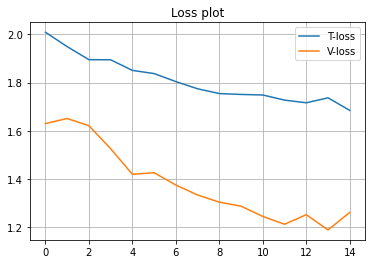

In [42]:
plt.figure()
plt.plot(epoch_loss, label='T-loss')
plt.plot(epoch_vl, label='V-loss')
plt.title('Loss plot')
plt.grid()
plt.legend()
plt.show()

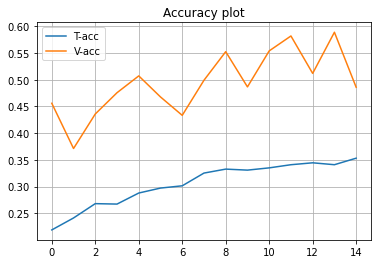

In [43]:
plt.figure()
plt.plot(epoch_acc, label='T-acc')
plt.plot(epoch_va, label='V-acc')
plt.title('Accuracy plot')
plt.grid()
plt.legend()
plt.show()